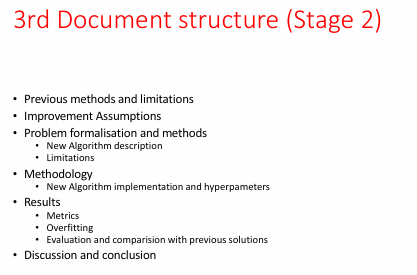

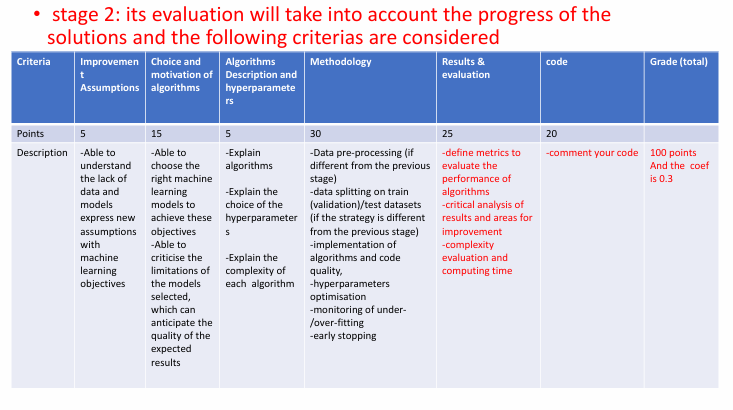

# Imports

In [ ]:
import pandas as pd  
import sklearn 
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn import tree
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from lightgbm import LGBMRegressor
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import joblib

In [3]:
data=pd.read_csv('train.csv')

# 1st approach: XGBoost

In [4]:
df=data
X = df[['Gb(i)', 'Gd(i)', 'H_sun', 'T2m', 'WS10m']]  # Drop target and categorical columns
y = df[['residual_load']]

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)
total_data = df[['P','Gb(i)', 'Gd(i)', 'H_sun', 'T2m', 'WS10m','load','residual_load']]

X_train shape: (70969, 5)
X_test shape: (17743, 5)
y_train shape: (70969, 1)
y_test shape: (17743, 1)


We will start by using XGBoost to predict the residual load directly.<br>
We start by applying a grid search to find the best hyperparameters for the model.

In [ ]:
# Define the parameter grid
param_grid = {
  'n_estimators': [100, 150, 200],
  'learning_rate': [0.01, 0.1, 0.2],
  'max_depth': [4, 6, 8]
}

# Initialize the model
model = xgb.XGBRegressor(objective='reg:squarederror')

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=2)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = np.sqrt(-grid_search.best_score_)
print(f"Best parameters: {best_params}")
print(f"Best RMSE: {best_score}")

# Train the model with the best parameters
best_model = grid_search.best_estimator_
best_model.fit(X_train, y_train)

# Validation Performance
y_pred_val = best_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_val))
print(f"XGBoost Validation RMSE: {rmse}")

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best parameters: {'learning_rate': 0.2, 'max_depth': 8, 'n_estimators': 200}
Best RMSE: 55.16128594945973
XGBoost Validation RMSE: 54.11680100992657


We now perform a cross-validation to evaluate the model.

In [6]:
from sklearn.model_selection import cross_val_score

# Initialize the model with the best parameters
best_model = xgb.XGBRegressor(objective='reg:squarederror', 
        learning_rate=0.2, 
        max_depth=8, 
        n_estimators=200)

# Perform cross-validation
cv_scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
cv_rmse = np.sqrt(-cv_scores)
print(f"Cross-Validation RMSE scores: {cv_rmse}")
print(f"Mean CV RMSE: {cv_rmse.mean()}")

# Train the model with the training data
best_model.fit(X_train, y_train)

# Validation Performance
y_pred_val = best_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_val))
print(f"XGBoost Validation RMSE: {rmse}")
joblib.dump(best_model,'XgboostBest.pkl')

Cross-Validation RMSE scores: [55.05470595 55.45825904 54.85567035 55.89233317 54.53531624]
Mean CV RMSE: 55.15925695158474
XGBoost Validation RMSE: 54.11680100992657


['XgboostBest.pkl']

# 2nd approach: Simple NN

In [6]:
df=data
X = df[['Gb(i)', 'Gd(i)', 'H_sun', 'T2m', 'WS10m']]  # Drop target and categorical columns
y = df[['residual_load']]

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)
total_data = df[['P','Gb(i)', 'Gd(i)', 'H_sun', 'T2m', 'WS10m','load','residual_load']]

X_train shape: (70969, 5)
X_test shape: (17743, 5)
y_train shape: (70969, 1)
y_test shape: (17743, 1)


The following code defines and compiles a neural network model using the Keras library.

1. **Model Definition**:
    - `Dense(64, input_dim=X_train_scaled.shape[1], activation='relu')`: The first layer is a dense (fully connected) layer with 64 neurons. It takes input with the same number of features as `X_train_scaled` and uses the ReLU activation function.
    - `Dropout(0.2)`: This layer helps prevent overfitting by randomly setting 20% of the input units to 0 at each update during training.
    - `Dense(32, activation='relu')`: The second dense layer has 32 neurons and uses the ReLU activation function.
    - `Dropout(0.2)`: Another dropout layer with a 20% dropout rate.
    - `Dense(16, activation='relu')`: The third dense layer has 16 neurons and uses the ReLU activation function.
    - `Dense(1)`: The output layer has a single neuron, suitable for regression tasks.

2. **Model Compilation**:
    - `optimizer='adam'`: The Adam optimizer is used for training the model.
    - `loss='mse'`: The mean squared error (MSE) loss function is used, which is suitable for regression tasks.
    - `metrics=['mse']`: The model will also track the mean squared error during training and evaluation.

In [19]:
# Normalize Features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train_scaled, X_val_scaled, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Build Neural Network
model_nn = Sequential([
    Dense(64, input_dim=X_train_scaled.shape[1], activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1)  # Single output for regression
])

model_nn.compile(optimizer='adam', loss='mse', metrics=['mse'])

# Train the Model
history = model_nn.fit(X_train_scaled, y_train, validation_data=(X_val_scaled, y_val), epochs=50, batch_size=32, verbose=1)

# Validation Performance
y_pred_val_nn = model_nn.predict(X_val_scaled)
rmse_nn = np.sqrt(mean_squared_error(y_val, y_pred_val_nn))
print(f"Neural Network Validation RMSE: {rmse_nn}")

Epoch 1/50
2218/2218 [==============================] - 3s 1ms/step - loss: 5657.5312 - mse: 5657.5312 - val_loss: 3976.2043 - val_mse: 3976.2043
Epoch 2/50
2218/2218 [==============================] - 2s 1ms/step - loss: 4445.6851 - mse: 4445.6851 - val_loss: 3900.8430 - val_mse: 3900.8430
Epoch 3/50
2218/2218 [==============================] - 2s 1ms/step - loss: 4364.0117 - mse: 4364.0117 - val_loss: 3877.8818 - val_mse: 3877.8818
Epoch 4/50
2218/2218 [==============================] - 2s 1ms/step - loss: 4319.4268 - mse: 4319.4268 - val_loss: 3845.7839 - val_mse: 3845.7839
Epoch 5/50
2218/2218 [==============================] - 2s 985us/step - loss: 4288.5894 - mse: 4288.5894 - val_loss: 3830.8557 - val_mse: 3830.8557
Epoch 6/50
2218/2218 [==============================] - 2s 987us/step - loss: 4255.7695 - mse: 4255.7695 - val_loss: 3816.1511 - val_mse: 3816.1511
Epoch 7/50
2218/2218 [==============================] - 2s 988us/step - loss: 4243.9854 - mse: 4243.9854 - val_loss: 388

# 3rd approach: Comparison of previously seen models, by calculating P and load to determine the residual load

We try a new method by predicting load and P and then we calculate the residual load.<br>
$residual\_load = load - P$


We define the gridsearch for each model we want to test: Random Forest, Linear Regression, and XGBoost.

In [7]:
features = df[['Gb(i)', 'Gd(i)', 'H_sun', 'T2m', 'WS10m']]
target_load = df['load']
target_P = df['P']


# Split the data into train and test sets
X_train, X_test, y_load_train, y_load_test, y_P_train, y_P_test = train_test_split(
    features, target_load, target_P, test_size=0.2, random_state=42
)

# Define the models and their parameter grids
param_grids = {
    'RandomForest': {
        'n_estimators': [50, 100, 200],
        'max_depth': [5, 10, 20],
        'min_samples_split': [2, 5, 10]
    },
    'LinearRegression': {
        # Linear Regression doesn't require much tuning
        'fit_intercept': [True, False]
    },
    'XGBoost': {
        'n_estimators': [50, 100],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 6, 8, 10]
    }
}
# Define the models
models = {
    'RandomForest': RandomForestRegressor(random_state=42),
    'LinearRegression': LinearRegression(),
    'XGBoost': XGBRegressor(random_state=42)
}

For each model, we perform the grid search to find the best hyperparameters and then evaluate the model using cross-validation.

In [8]:
# Perform GridSearchCV and Cross Validation for each model
results = {}

for name, model in models.items():
    print(f"\nPerforming Grid Search for {name}")
    
    # Get the parameter grid for the model
    param_grid = param_grids.get(name, {})
    
    # Perform GridSearchCV
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1, scoring='neg_mean_squared_error')
    grid_search.fit(X_train, y_load_train)  # Grid search for 'load' prediction

    print(f"Best parameters for {name} (load): {grid_search.best_params_}")
    best_model_load = grid_search.best_estimator_

    # Evaluate using cross-validation on 'load'
    cv_scores_load = cross_val_score(best_model_load, X_train, y_load_train, cv=3, scoring='neg_mean_squared_error')
    rmse_load = np.sqrt(-cv_scores_load)  # Convert MSE to RMSE
    print(f"Cross-validation RMSE for {name} (load): {rmse_load}")
    print(f"Mean CV RMSE for {name} (load): {rmse_load.mean()}")

    # Train the best model for 'P'
    grid_search.fit(X_train, y_P_train)  # Grid search for 'P' prediction
    print(f"Best parameters for {name} (P): {grid_search.best_params_}")
    best_model_P = grid_search.best_estimator_

    # Evaluate using cross-validation on 'P'
    cv_scores_P = cross_val_score(best_model_P, X_train, y_P_train, cv=3, scoring='neg_mean_squared_error')
    rmse_P = np.sqrt(-cv_scores_P)  # Convert MSE to RMSE
    print(f"Cross-validation RMSE for {name} (P): {rmse_P}")
    print(f"Mean CV RMSE for {name} (P): {rmse_P.mean()}")

    # Make predictions with the best models
    y_load_pred = best_model_load.predict(X_test)
    y_P_pred = best_model_P.predict(X_test)

    # Calculate residual load
    residual_load_pred = y_load_pred - y_P_pred
    true_residual_load = y_load_test - y_P_test

    # Calculate RMSE for residual load
    mse_residual = mean_squared_error(true_residual_load, residual_load_pred)
    rmse_residual = np.sqrt(mse_residual)
    print(f"Residual Load RMSE for {name}: {rmse_residual}")

    # Store results
    results[name] = {
        'best_model_load': best_model_load,
        'best_model_P': best_model_P,
        'rmse_residual': rmse_residual
    }



Performing Grid Search for RandomForest
Best parameters for RandomForest (load): {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}
Cross-validation RMSE for RandomForest (load): [37.22913087 37.56712941 37.74139207]
Mean CV RMSE for RandomForest (load): 37.512550784509905
Best parameters for RandomForest (P): {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}
Cross-validation RMSE for RandomForest (P): [40.93923224 40.51565902 40.63485479]
Mean CV RMSE for RandomForest (P): 40.69658201661171
Residual Load RMSE for RandomForest: 53.50422241479942

Performing Grid Search for LinearRegression
Best parameters for LinearRegression (load): {'fit_intercept': True}
Cross-validation RMSE for LinearRegression (load): [46.2152167  46.18887281 46.75970817]
Mean CV RMSE for LinearRegression (load): 46.38793256190767
Best parameters for LinearRegression (P): {'fit_intercept': False}
Cross-validation RMSE for LinearRegression (P): [44.9064675  44.58126124 44.40256423]
Mean C

In [9]:
print("\nFinal Results:")
for name, result in results.items():
    print(f"\n{name} - Residual Load RMSE: {result['rmse_residual']}")


Final Results:

RandomForest - Residual Load RMSE: 53.50422241479942

LinearRegression - Residual Load RMSE: 64.21044483417955

XGBoost - Residual Load RMSE: 53.59024667112735


In [10]:
# Store the best models for load and P prediction
best_model_load = None
best_model_P = None
best_rmse_load = float('inf')
best_rmse_P = float('inf')

# Perform GridSearchCV and Cross Validation for each model
for name, model in models.items():
    print(f"\nPerforming Grid Search for {name}")
    
    # Get the parameter grid for the model
    param_grid = param_grids.get(name, {})
    
    # Perform GridSearchCV for load prediction
    grid_search_load = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')
    grid_search_load.fit(X_train, y_load_train)  # Grid search for 'load' prediction
    
    print(f"Best parameters for {name} (load): {grid_search_load.best_params_}")
    
    best_model_load_temp = grid_search_load.best_estimator_

    # Evaluate using cross-validation on 'load'
    cv_scores_load = cross_val_score(best_model_load_temp, X_train, y_load_train, cv=5, scoring='neg_mean_squared_error')
    rmse_load = np.sqrt(-cv_scores_load)  # Convert MSE to RMSE
    print(f"Cross-validation RMSE for {name} (load): {rmse_load}")
    print(f"Mean CV RMSE for {name} (load): {rmse_load.mean()}")

    # Check if this is the best model for 'load'
    if rmse_load.mean() < best_rmse_load:
        best_rmse_load = rmse_load.mean()
        best_model_load = best_model_load_temp
        print(f"Best model for 'load' updated: {name} with RMSE: {best_rmse_load}")

    # Perform GridSearchCV for P prediction
    grid_search_P = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')
    grid_search_P.fit(X_train, y_P_train)  # Grid search for 'P' prediction
    
    print(f"Best parameters for {name} (P): {grid_search_P.best_params_}")
    
    best_model_P_temp = grid_search_P.best_estimator_

    # Evaluate using cross-validation on 'P'
    cv_scores_P = cross_val_score(best_model_P_temp, X_train, y_P_train, cv=5, scoring='neg_mean_squared_error')
    rmse_P = np.sqrt(-cv_scores_P)  # Convert MSE to RMSE
    print(f"Cross-validation RMSE for {name} (P): {rmse_P}")
    print(f"Mean CV RMSE for {name} (P): {rmse_P.mean()}")

    # Check if this is the best model for 'P'
    if rmse_P.mean() < best_rmse_P:
        best_rmse_P = rmse_P.mean()
        best_model_P = best_model_P_temp
        print(f"Best model for 'P' updated: {name} with RMSE: {best_rmse_P}")

# Make predictions with the best models for 'load' and 'P'
y_load_pred = best_model_load.predict(X_test)
y_P_pred = best_model_P.predict(X_test)

# Calculate residual load
residual_load_pred = y_load_pred - y_P_pred
true_residual_load = y_load_test - y_P_test

# Calculate RMSE for residual load
mse_residual = mean_squared_error(true_residual_load, residual_load_pred)
rmse_residual = np.sqrt(mse_residual)
print(f"Residual Load RMSE for Best Models: {rmse_residual}")


Performing Grid Search for RandomForest
Best parameters for RandomForest (load): {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}
Cross-validation RMSE for RandomForest (load): [36.47843485 36.821001   37.00315469 37.27741695 36.80055541]
Mean CV RMSE for RandomForest (load): 36.87611258189262
Best model for 'load' updated: RandomForest with RMSE: 36.87611258189262
Best parameters for RandomForest (P): {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}
Cross-validation RMSE for RandomForest (P): [40.61697247 40.6530235  39.7487977  40.05988661 40.49586085]
Mean CV RMSE for RandomForest (P): 40.31490822469399
Best model for 'P' updated: RandomForest with RMSE: 40.31490822469399

Performing Grid Search for LinearRegression
Best parameters for LinearRegression (load): {'fit_intercept': True}
Cross-validation RMSE for LinearRegression (load): [46.25638508 46.16627829 46.13544415 46.63398008 46.74589554]
Mean CV RMSE for LinearRegression (load): 46.387596629775416

To increase the accuracy of our algorithm we implement a new method always with separate prediction of P and load.

Since P and load are predicted separately, and P represents the amount of energy generated by the photovoltaic system, we can transform gdi and gbi respectively (Diffuse in-plane irradiance. This is the fraction of solar radiation that reaches the ground after being reflected or scattered by the atmosphere. It is also available if clouds block the sun, Direct in-plane irradiance. This is the fraction of solar radiation that reaches the ground directly. It is only available if clouds are not blocking the sun.) To predict P, we sum gdi and gbi

As load represents the energy used to operate the solar panel, it does not depend on the sun but on climatic conditions, mainly air temperature and wind.To predict load we mainly use time(hour, day of the week and month), T2M and WS10m.

In [11]:
train_df=pd.read_csv('train.csv', parse_dates = True, index_col = 'time')
solar_model = RandomForestRegressor()

train_df.loc[:,'total_G'] = train_df.loc[:, 'Gb(i)'] + train_df.loc[:,'Gd(i)']   # summed to overcome data issues
solar_X = ['total_G','H_sun']
solar_y = ['P']

The purpose of the following function is to make several faith predictions on our data and select the ones that are really useful for prediction (that have an error < treshold). By returning the filtered dataframe, future predictions will be more accurate. 

In [12]:
def model_repeat(model, rounds, X_cols, y_col, df, error_multiplier):
    
    scores = []
    length = []
    
    for round in range(rounds):
        
        # Number of rows for itteration
        length.append(len(df.index))
        
        # Set X and y columns and df for iteration and calculate mean rmse
        X = df.loc[:,X_cols]
        y = df.loc[:,'P']
        scores.append(np.mean(np.absolute(
            cross_val_score(model, X, y, scoring='neg_root_mean_squared_error', cv = 3))))
        
        # Fit mode and generate predictions, squared error for each prediction
        solar_model3=model.fit(X,y)
        df.loc[:,'y_pred'] = solar_model3.predict(X)
        df.loc[:,'sq_error']= np.square(df.loc[:,'y_pred'] - y)
        sq_error_threshold = error_multiplier * df.loc[:,'sq_error'].mean()
        # we use the error_multiplier variable to remove only those predictions with too little precision, while retaining the majority of the data. This variable is arbitrarily chosen
        
        df = df.loc[df.sq_error < sq_error_threshold]
        
        
    return df, scores, length

In [13]:
def accuracy_P(df,model,model2): #used to make predictions with different models for repeat
    solar_X = ['total_G','H_sun']
    solar_y = ['P']
    results = model_repeat(solar_model, 2, solar_X, solar_y, df, 5)
    iterated_solar_df = results[0]
    scores_results = results[1]
    length_results = results[2]
    #filtered dataframe is used for prediction
    iterated_solar_df.loc[:,'total_G'] = iterated_solar_df.loc[:, 'Gb(i)'] + iterated_solar_df.loc[:,'Gd(i)']   # summed to overcome data issues
    solar_X = iterated_solar_df.loc[:,['total_G','H_sun']]
    solar_y = iterated_solar_df.loc[:,'P'] 
    print(model2)
    solar_scores = np.absolute(cross_val_score(model2, solar_X, solar_y, scoring='neg_root_mean_squared_error', cv = 3))
    print("Model : ",model)
    print("Mean cross-validation score: %.2f" % solar_scores.mean())
    return


In [14]:
for models in [RandomForestRegressor(),XGBRegressor(),LGBMRegressor()]:
    accuracy_P(train_df,models,XGBRegressor(n_estimators=50, max_depth=10,learning_rate=0.1))

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=50, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)
Model :  RandomForestRegressor()
Mean cross-validation score: 17.02
XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds

We can see that the model used in the repeat hardly changes the precision, which seems logical since the models make the same errors on the outliers, so the filtered dataset is close for each model.

In [91]:
for models in [XGBRegressor()]:
    accuracy_P(train_df,models,RandomForestRegressor(max_depth=20,min_samples_split=2,n_estimators=200))

RandomForestRegressor(max_depth=20, n_estimators=200)
Model :  XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)
Mean cross-validation score: 17.01


We can see, however, that the model used to make the predictions and its parameters are always very important.

In [95]:
load_X = train_df.loc[:,['T2m','WS10m']]
load_X.loc[:,'month'] = load_X.index.month
load_X.loc[:,'day_of_week'] = load_X.index.day_of_week
load_X.loc[:,'hour'] = load_X.index.hour
load_y = train_df['load']
#The idea here is that energy consumption depends on the wind and on the temperature, but also on the time of year, so we take the day, month and year of the date on which we've indexed our dataframe. 
print(load_X.head())

load_model = XGBRegressor(learning_rate= 0.1, max_depth= 7, n_estimators= 50)
load_scores = np.absolute(cross_val_score(load_model, load_X, load_y, scoring='neg_root_mean_squared_error', cv = 3))
print("Mean cross-validation score: %.2f" % load_scores.mean())
X_train, X_test, y_load_train, y_load_test = train_test_split( load_X, load_y, test_size=0.2, random_state=42)


                      T2m  WS10m  month  day_of_week  hour
time                                                      
2018-01-01 00:00:00  9.11   5.38      1            0     0
2018-01-01 00:15:00  8.89   5.43      1            0     0
2018-01-01 00:30:00  8.66   5.48      1            0     0
2018-01-01 00:45:00  8.44   5.54      1            0     0
2018-01-01 01:00:00  8.22   5.59      1            0     1
Mean cross-validation score: 23.77


# 4th approach: LSTM

We build a simple Neural Network using LSTM layers to predict the residual load:


1. **Model Definition**:
    - `LSTM(64, activation='relu', input_shape=(SEQ_LENGTH, X.shape[2]), return_sequences=True)`: The first LSTM layer has 64 units and uses the ReLU activation function. The input shape is defined as a tuple containing the sequence length and the number of features in the input data. The `return_sequences=True` argument is used to return the full sequence of outputs.
    - `Dropout(0.2)`: This layer helps prevent overfitting by randomly setting 20% of the input units to 0 at each update during training.
    - `LSTM(32, activation='relu')`: The second LSTM layer has 32 units and uses the ReLU activation function.
    - `Dense(1)`: The output layer has a single neuron, suitable for regression tasks.

2. **Model Compilation**:
    - `optimizer='adam'`: The Adam optimizer is used for training the model.
    - `loss='mse'`: The mean squared error (MSE) loss function is used, which is suitable for regression tasks.

C:\Users\thoma\AppData\Roaming\Python\Python39\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_13 (LSTM)                  │ (None, 6, 64)          │        17,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 6, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_14 (LSTM)                  │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,601 (115.63 KB)

 Trainable params: 29,601 (115.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
2218/2218 ━━━━━━━━━━━━━━━━━━━━ 26s 10ms/step - loss: 0.0332 - val_loss: 0.0058
Epoch 2/5
2218/2218 ━━━━━━━━━━━━━━━━━━━━ 19s 9ms/step - loss: 0.0073 - val_loss: 0.0059
Epoch 3/5
2218/2218 ━━━━━━━━━━━━━━━━━━━━ 17s 8ms/step - loss: 0.0061 - val_loss: 0.0067
Epoch 4/5
2218/2218 ━━━━━━━━━━━━━━━━━━━━ 17s 8ms/step - loss: 0.0057 - val_loss: 0.0055
Epoch 5/5
2218/2218 ━━━━━━━━━━━━━━━━━━━━ 17s 8ms/step - loss: 0.0058 - val_loss: 0.0058
555/555 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
RMSE: 67.76101046014854


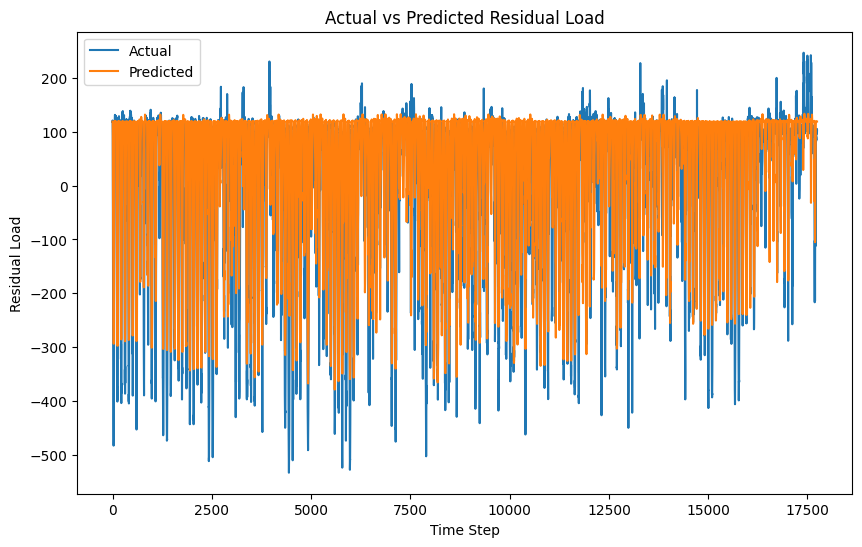

In [8]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from math import sqrt
import matplotlib.pyplot as plt

# Load training data
data = pd.read_csv('train.csv')
data['time'] = pd.to_datetime(data['time'])
data.set_index('time', inplace=True)

# Feature scaling
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data[['Gb(i)', 'H_sun', 'residual_load']])

# Prepare the data for LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length, :-1])  # Features
        y.append(data[i+seq_length, -1])    # Target (residual_load)
    return np.array(X), np.array(y)

SEQ_LENGTH = 6  # 12 timesteps (3 hours if 15 min intervals)
X, y = create_sequences(scaled_data, SEQ_LENGTH)

# Train-test split
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Build the LSTM model
model = Sequential([
    LSTM(64, activation='relu', return_sequences=True, input_shape=(SEQ_LENGTH, X.shape[2])),
    Dropout(0.2),
    LSTM(32, activation='relu'),
    Dropout(0.2),
    Dense(1)  # Single output for regression
])

model.compile(optimizer='adam', loss='mse')
model.summary()

# Train the model
history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# Make predictions
y_pred = model.predict(X_test)

# Inverse scale the predictions
y_test_rescaled = scaler.inverse_transform(
    np.hstack([np.zeros((y_test.shape[0], scaled_data.shape[1] - 1)), y_test.reshape(-1, 1)])
)[:, -1]
y_pred_rescaled = scaler.inverse_transform(
    np.hstack([np.zeros((y_pred.shape[0], scaled_data.shape[1] - 1)), y_pred])
)[:, -1]

# Evaluate with RMSE
rmse = sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
print(f"RMSE: {rmse}")

# Plot actual vs predicted
plt.figure(figsize=(10, 6))
plt.plot(y_test_rescaled, label='Actual')
plt.plot(y_pred_rescaled, label='Predicted')
plt.title('Actual vs Predicted Residual Load')
plt.xlabel('Time Step')
plt.ylabel('Residual Load')
plt.legend()
plt.show()



# Testing the best model found on the test data

In [ ]:
sample_ready = pd.read_csv('test.csv')

In [ ]:
sample_test = sample_ready[['Gb(i)','Gd(i)','H_sun','T2m','WS10m']]

In [45]:
sample_test = sample_test.reset_index(drop=True)
sample_test

,Gb(i),Gd(i),H_sun,T2m,WS10m
0,0.0,0.0,0.0,1.76,1.52
1,0.0,0.0,0.0,1.57,1.52
2,0.0,0.0,0.0,1.38,1.52
3,0.0,0.0,0.0,1.19,1.52
4,0.0,0.0,0.0,1.00,1.52
...,...,...,...,...,...
7387,0.0,0.0,0.0,4.25,1.38
7388,0.0,0.0,0.0,4.16,1.38
7389,0.0,0.0,0.0,4.06,1.40
7390,0.0,0.0,0.0,3.96,1.42


In [48]:
model=joblib.load('XgboostBest.pkl')

In [49]:
predic=model.predict(sample_test)

In [50]:
predic

array([130.98134, 130.98134, 130.98134, ..., 127.32978, 126.52043,
       128.58429], dtype=float32)

In [51]:
sub=sample_ready[['time']]

In [52]:
predic_df = pd.DataFrame(predic, columns=['residual_load'])
merged_df = pd.concat([sub, predic_df], axis=1)
merged_df.to_csv('Xgboost.csv',index=False)